# Lasso Regression

In this notebook, we shall delve into the practical application of the Least Absolute Shrinkage and Selection Operator, commonly abbreviated as LASSO. Our objective is to assess its efficacy in two separate scenarios: one involving irregular coefficients and another with regular coefficients.

Though ridge regression has a great many applications and uses, there is one thing to note: it does not perform variable selection.

Lasso regression aids in variable selection and can entirely nullify certain coefficients. However, does this methodology perform equally effectively in the two aforementioned scenarios?
 
we will generate artificial datasets to illustrate and evaluate the functionality of Lasso regression. One dataset will be intentionally designed to exhibit multicollinearity, a situation where the explanatory variables are highly correlated with one another, posing a challenge for traditional regression techniques. The other dataset will be structured with a regular matrix of explanatory variables, representing a scenario where relationships between variables adhere to more conventional patterns. By applying Lasso regression to these two distinct datasets, we aim to examine its performance in variable selection and coefficient estimation under both scenarios, shedding light on its versatility and effectiveness in handling diverse real-world data complexities.

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

RSEED = 42

# define figure size
plt.rcParams['figure.figsize'] = (10, 7)

In [216]:
# Create Variables
np.random.seed(RSEED)

# Independent Variables
X1 = 2 * np.random.rand(500,1)
X2 = np.random.normal(30, 20, (500,1))
X3 = np.random.gamma(2, 5, (500, 1))
X4 = -0.5 * np.random.rand(500,1)
X5 = 3 * np.random.normal(50, 60, (500,1))
X6 = np.random.normal(0, 1, (500,1))

# Variables that are linear combination of X1 - X6 variables
X7 = 4 + 0.95 * X1
X8 = 0.98 * X5
X9 = -0.99 * X3
X10 = 18 - 0.80 * X6
X11 = 0.75 * X1
X12 = 0.97 * X2

# Variables that are not linear combination of X1-X6 variables
X13 = 0.25 * X2**2
X14 = 10 + X4**3
X15 = -0.19 * X3*X5
X16 = 0.20 * X6
X17 = 45 + 0.15 * X1**X2
X18 = 0.35 * np.abs(X5)**0.8 * X1

# Dependent Variables
noise1 = np.random.normal(0, 1, (500, 1)) 
y1 = 10 + 2*X1 + 0.5*X3 + 20*X4 + 3*X5 + 40*X6 + 22*X7 + 0.85*X8 + 6.5*X9 + 12*X10 + 2*X12 + 23*X13 + 4*X18 + noise1
noise2 = np.random.normal(0, 1, (500, 1)) 
y2 = 34 + 12*X1 + 5*X3 + 13*X4 + noise2



In [217]:
# Create a DataFrame with multicolinearity
data = {
    'X1': X1.flatten(),
    'X2': X2.flatten(),
    'X3': X3.flatten(),
    'X4': X4.flatten(),
    'X5': X5.flatten(),
    'X6': X6.flatten(),
    'X7': X7.flatten(),
    'X8': X8.flatten(),
    'X9': X9.flatten(),
    'X10': X10.flatten(),
    'X11': X11.flatten(),
    'X12': X12.flatten(),
    'X13': X13.flatten(),
    'X14': X14.flatten(),
    'X15': X15.flatten(),
    'X16': X16.flatten(),
    'X17': X17.flatten(),
    'X18': X18.flatten(),
    'y1': y1.flatten(),
    'y2': y2.flatten()
}

df = pd.DataFrame(data)

df.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,y1,y2
0,0.749080,36.835120,12.699421,-0.043546,34.532356,0.622070,4.711626,33.841709,-12.572426,17.502344,0.561810,35.730066,339.206507,9.999917,-83.322774,0.124414,4.500000e+01,4.458383,8296.856413,106.853091
1,1.901429,67.523417,6.222611,-0.308533,237.817011,1.328933,5.806357,233.060671,-6.160385,16.936853,1.426071,65.497714,1139.852954,9.970630,-281.170127,0.265787,1.048403e+18,52.983715,27826.378562,83.696546
2,1.463988,49.008477,14.830738,-0.056919,474.782660,0.386809,5.390788,465.287007,-14.682431,17.690553,1.097991,47.538222,600.457699,9.999816,-1337.861674,0.077362,1.944608e+07,70.925337,16279.457459,126.046767
3,1.197317,18.461927,12.055376,-0.172612,115.637317,1.090980,5.137451,113.324571,-11.934822,17.127216,0.897988,17.908069,85.210686,9.994857,-264.869751,0.218196,4.916853e+01,18.739396,2813.866262,107.853349
4,0.312037,12.031707,20.817823,-0.253706,279.556430,2.012270,4.296435,273.965301,-20.609645,16.390184,0.234028,11.670755,36.190491,9.983670,-1105.753702,0.402454,4.500000e+01,9.895782,2220.758786,137.619065


In [218]:
# define features for the model 1
features_1 = df.columns.tolist()
features_1.remove('y1')
features_1.remove('y2')
features_1.remove('X1')
features_1.remove('X7')
features_1.remove('X11')
X_1 = df[features_1]
y_1 = df['y1']

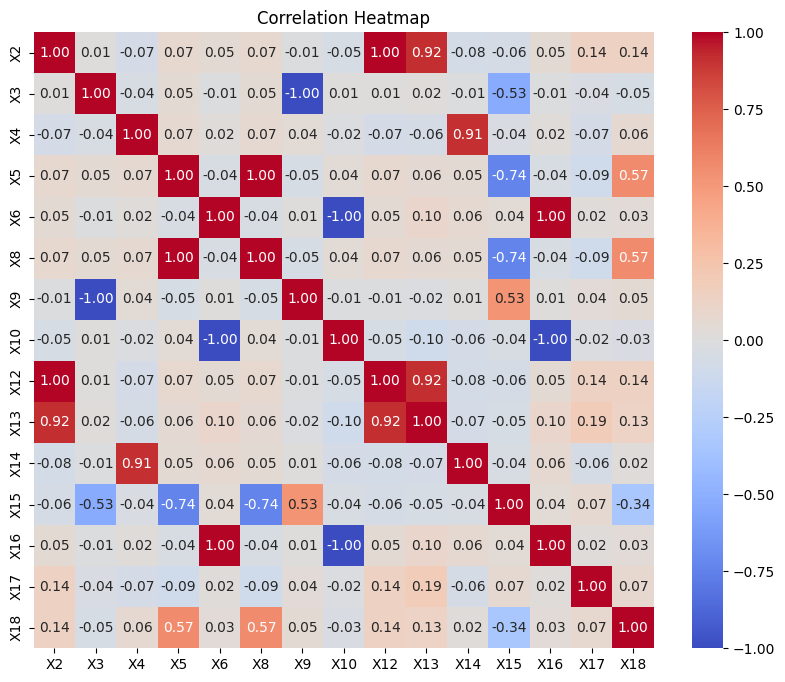

In [219]:
corr_matrix_1 = X_1.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix_1, annot=True, cmap='coolwarm', fmt=".2f")  
plt.title("Correlation Heatmap")  
plt.show()  

In [220]:
# define features for the model 2
features_2 = df.columns.tolist()
features_2.remove('y1')
features_2.remove('y2')
features_2.remove('X1')
features_2.remove('X7')
features_2.remove('X11')
columns_to_remove = ['X8', 'X9', 'X10', 'X12', 'X13', 'X14', 'X16']
features_2 = [col for col in features_2 if col not in columns_to_remove]

X_2 = df[features_2]
y_2 = df['y2']

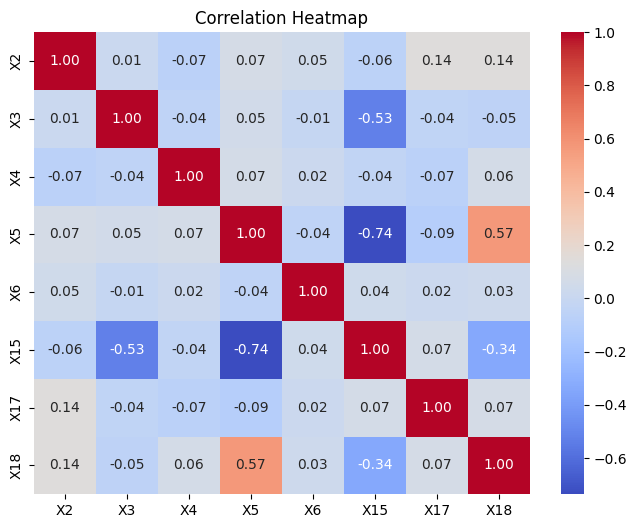

In [221]:
corr_matrix_2 = X_2.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm', fmt=".2f")  
plt.title("Correlation Heatmap")  
plt.show()  

In [222]:
# train-test-split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=RSEED, test_size=0.4)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=RSEED, test_size=0.4)
print(X_train_1.shape)
print(X_train_2.shape)

(300, 15)
(300, 8)


In [223]:
# Initialize and train model
lin_reg_1 = LinearRegression()
lin_reg_2 = LinearRegression()
lin_reg_1.fit(X_train_1, y_train_1)
lin_reg_2.fit(X_train_2, y_train_2)

# Predict on test-set
y_pred_test_1 = lin_reg_1.predict(X_test_1)
y_pred_train_1 = lin_reg_1.predict(X_train_1)
y_pred_test_2 = lin_reg_2.predict(X_test_2)
y_pred_train_2 = lin_reg_2.predict(X_train_2)

# Calculate RMSE on train and test set
train_rmse_1 = np.sqrt(mean_squared_error(y_train_1, y_pred_train_1))
test_rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_test_1))
train_rmse_2 = np.sqrt(mean_squared_error(y_train_2, y_pred_train_2))
test_rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_test_2))

# Calculate R2 score on train and test set
train_r2_1 = r2_score(y_train_1, y_pred_train_1)
test_r2_1 = r2_score(y_test_1, y_pred_test_1)
train_r2_2 = r2_score(y_train_2, y_pred_train_2)
test_r2_2 = r2_score(y_test_2, y_pred_test_2)

# Print RMSE and R2 values
print("Model 1:")
print("Train RMSE:", round(train_rmse_1, 3))
print("Test RMSE:", round(test_rmse_1, 3))
print("Train R-squared (R2):", round(train_r2_1, 3))
print("Test R-squared (R2):", round(test_r2_1, 3))

print("\nModel 2:")
print("Train RMSE:", round(train_rmse_2, 3))
print("Test RMSE:", round(test_rmse_2, 3))
print("Train R-squared (R2):", round(train_r2_2, 3))
print("Test R-squared (R2):", round(test_r2_2, 3))



Model 1:
Train RMSE: 7221.525
Test RMSE: 8698.223
Train R-squared (R2): 0.087
Test R-squared (R2): 0.032

Model 2:
Train RMSE: 32.215
Test RMSE: 31.407
Train R-squared (R2): 0.17
Test R-squared (R2): 0.277


In [224]:
# Get the coefficients and intercept for Model 1
intercept_1 = lin_reg_1.intercept_
coefficients_1 = lin_reg_1.coef_

# Get the coefficients and intercept for Model 2
intercept_2 = lin_reg_2.intercept_
coefficients_2 = lin_reg_2.coef_

# Create a list of feature names for Model 1 and Model 2
feature_names_1 = X_1.columns.tolist()
feature_names_2 = X_2.columns.tolist()

# Print regression equations for Model 1 and Model 2
print("\nRegression Equation for Model 1:")
equation_1 = f"y1 = {intercept_1:.1f} "
for i, coef in enumerate(coefficients_1):
    equation_1 += f"+ {coef:.3f}*{feature_names_1[i]} "
print(equation_1)

print("\nRegression Equation for Model 2:")
equation_2 = f"y2 = {intercept_2:.1f} "
for i, coef in enumerate(coefficients_2):
    equation_2 += f"+ {coef:.3f}*{feature_names_2[i]} "
print(equation_2)


Regression Equation for Model 1:
y1 = 7317.1 + 0.009*X2 + -0.000*X3 + -0.000*X4 + 0.712*X5 + 0.000*X6 + 0.698*X8 + -0.014*X9 + -0.000*X10 + 0.009*X12 + 0.137*X13 + -0.000*X14 + -2.231*X15 + 0.000*X16 + 0.000*X17 + 0.046*X18 

Regression Equation for Model 2:
y2 = 84.5 + 0.000*X2 + -0.000*X3 + -0.000*X4 + 0.009*X5 + 0.000*X6 + -0.030*X15 + -0.000*X17 + 0.001*X18 


True models:

$y_{1} = 10 + 2X_{1} + 0.5X_{3} + 20X_{4} + 3X_{5} + 40X_{6} + 22X_{7} + 0.85X_{8} + 6.5X_{9} + 12X_{10} + 2X_{12} + 23X_{13} + 4X_{18} + \epsilon_{1}$
<br> $y_{2} = 34 + 12X_{1} + 5X_{3} + 13X_{4} + \epsilon_{2}$

Note:

RMSE provides a single number that summarizes how well a predictive model is performing. Lower RMSE values indicate better model performance because they indicate that the model's predictions are closer to the actual values on average. RMSE is widely used in various fields, including machine learning, statistics, and economics, to evaluate the accuracy of predictive models and to compare different models or algorithms.

$$
\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$

In [225]:
def coeff_info(model, total_features):
    coeff_used = np.sum(model.coef_ != 0)
    print('The model is using', coeff_used, 'out of', total_features, 'features.')
    print("The highest coefficient has a value of:", max(model.coef_.round(3)))


In [226]:
print('Model 1:')
coeff_info(lin_reg_1, total_features=15)

print('Model 2:')
coeff_info(lin_reg_2, total_features=8)

Model 1:
The model is using 15 out of 15 features.
The highest coefficient has a value of: 0.712
Model 2:
The model is using 8 out of 8 features.
The highest coefficient has a value of: 0.009


In [227]:
from sklearn.linear_model import Lasso

In [228]:
# initialize and train model with (default value) alpha = 0.5
lasso_05_1 = Lasso(alpha=0.5, max_iter=int(10e5))
lasso_05_1.fit(X_train_1,y_train_1)

# predict on test-set
y_pred_test_lasso_1 = lasso_05_1.predict(X_test_1)
y_pred_train_lasso_1 = lasso_05_1.predict(X_train_1)

# Calculate RMSE on train and test set
train_rmse_lasso_1 = np.sqrt(mean_squared_error(y_train_1, y_pred_train_lasso_1))
test_rmse_lasso_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_test_lasso_1))

# Calculate R2 score on train and test set
train_r2_lasso_1 = r2_score(y_train_1, y_pred_train_lasso_1)
test_r2_lasso_1 = r2_score(y_test_1, y_pred_test_lasso_1)

# Print RMSE and R2 values
print("Lasso Model 1 (alpha=0.5):")
print("Train RMSE:", round(train_rmse_lasso_1, 3))
print("Test RMSE:", round(test_rmse_lasso_1, 3))
print("Train R-squared (R2):", round(train_r2_lasso_1, 3))
print("Test R-squared (R2):", round(test_r2_lasso_1, 3))

Lasso Model 1 (alpha=0.5):
Train RMSE: 9.093
Test RMSE: 8.812
Train R-squared (R2): 1.0
Test R-squared (R2): 1.0


In [229]:
print('Model 1:')
coeff_info(lasso_05_1, total_features=15)

Model 1:
The model is using 11 out of 15 features.
The highest coefficient has a value of: 29.777


In [230]:
# Get the coefficients and variable names
coefficients_1 = lasso_05_1.coef_
variable_names = ['X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'X9', 'X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

# Create a list of selected variables based on non-zero coefficients
selected_variables_1 = [var for coef, var in zip(coefficients_1, variable_names) if coef != 0]

# Print the selected variables in Model 1
print("Selected Variables in Model 1:", selected_variables_1)

Selected Variables in Model 1: ['X2', 'X3', 'X5', 'X6', 'X8', 'X9', 'X12', 'X13', 'X15', 'X17', 'X18']


In [231]:
# Print the regression equation for Model 2
print("\nRegression Equation for Model 1:")
equation_2 = f"y1 = {lasso_05_1.intercept_:.3f} "
for coef, var in zip(coefficients_1, selected_variables_1):
    equation_2 += f"+ {coef:.3f}*{var} "
print(equation_2)


Regression Equation for Model 1:
y1 = 326.168 + 3.303*X2 + -5.442*X3 + 0.000*X5 + 3.788*X6 + 29.777*X8 + 0.000*X9 + 0.552*X12 + -0.000*X13 + -1.478*X15 + 23.004*X17 + 0.000*X18 


True model:

$y_{1} = 10 + 2X_{1} + 0.5X_{3} + 20X_{4} + 3X_{5} + 40X_{6} + 22X_{7} + 0.85X_{8} + 6.5X_{9} + 12X_{10} + 2X_{12} + 23X_{13} + 4X_{18} + \epsilon_{1}$

In [232]:
# initialize and train model with (default value) alpha = 0.5
lasso_05_2 = Lasso(alpha=0.5, max_iter=int(10e5))
lasso_05_2.fit(X_train_2,y_train_2)

# predict on test-set
y_pred_test_lasso_2 = lasso_05_2.predict(X_test_2)
y_pred_train_lasso_2 = lasso_05_2.predict(X_train_2)

# Calculate RMSE on train and test set
train_rmse_lasso_2 = np.sqrt(mean_squared_error(y_train_2, y_pred_train_lasso_2))
test_rmse_lasso_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_test_lasso_2))

# Calculate R2 score on train and test set
train_r2_lasso_2 = r2_score(y_train_2, y_pred_train_lasso_2)
test_r2_lasso_2 = r2_score(y_test_2, y_pred_test_lasso_2)

# Print RMSE and R2 values
print("Lasso Model 2 (alpha=0.5):")
print("Train RMSE:", round(train_rmse_lasso_2, 3))
print("Test RMSE:", round(test_rmse_lasso_2, 3))
print("Train R-squared (R2):", round(train_r2_lasso_2, 3))
print("Test R-squared (R2):", round(test_r2_lasso_2, 3))

Lasso Model 2 (alpha=0.5):
Train RMSE: 4.907
Test RMSE: 4.975
Train R-squared (R2): 0.981
Test R-squared (R2): 0.982


In [233]:
print('Model 2:')
coeff_info(lasso_05_2, total_features=8)

Model 2:
The model is using 6 out of 8 features.
The highest coefficient has a value of: 4.924


In [234]:
# Get the coefficients and variable names
coefficients_2 = lasso_05_2.coef_
variable_names_2 = ['X2', 'X3', 'X4', 'X5', 'X6', 'X15', 'X17', 'X18']

# Create a list of selected variables based on non-zero coefficients
selected_variables_2 = [var for coef, var in zip(coefficients_2, variable_names_2) if coef != 0]

# Print the selected variables in Model 1
print("Selected Variables in Model 2:", selected_variables_2)

Selected Variables in Model 2: ['X2', 'X3', 'X5', 'X15', 'X17', 'X18']


In [235]:
# Print the regression equation for Model 2
print("\nRegression Equation for Model 2:")
equation_2 = f"y2 = {lasso_05_2.intercept_:.3f} "
for coef, var in zip(coefficients_2, selected_variables_2):
    equation_2 += f"+ {coef:.3f}*{var} "
print(equation_2)


Regression Equation for Model 2:
y2 = 39.916 + -0.008*X2 + 4.924*X3 + 0.000*X5 + -0.024*X15 + 0.000*X17 + -0.001*X18 


True model:

$y_{2} = 34 + 12X_{1} + 5X_{3} + 13X_{4} + \epsilon_{2}$